# Requirements

In [1]:
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# Writing data to a file

Suppose you want to store the following numpy arrays in an HDF5 file.

In [2]:
x_values = np.linspace(0.0, 1.0, 11)
y_values = np.linspace(-1.0, 1.0, 21)

Open the file for writing.

In [3]:
h5file = h5py.File('temp.h5', 'w')

Create a group.  This is not required, but it may help you to organize your data.

In [4]:
input_group = h5file.create_group('input')

Create a dataset in the group, the dataspace is determined by the data.

In [5]:
x_dset = input_group.create_dataset('x', data=x_values)
y_dset = input_group.create_dataset('y', data=y_values)

Close the file.

In [6]:
h5file.close()

In [7]:
!h5dump temp.h5

HDF5 "temp.h5" {
GROUP "/" {
   GROUP "input" {
      DATASET "x" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 11 ) / ( 11 ) }
         DATA {
         (0): 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
      DATASET "y" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 21 ) / ( 21 ) }
         DATA {
         (0): -1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
         (11): 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
   }
}
}


# Reading data from a file

Open the file for reading, this time using a context manager.

In [8]:
with h5py.File('temp.h5', 'r') as h5file:
    x_dset = h5file['input']['x']
    for value in x_dset:
        print(value)
    print(type(x_dset), x_dset.dtype, x_dset.shape)

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
<class 'h5py._hl.dataset.Dataset'> float64 (11,)


Note that HDF5 file objects and groups behave like dictionaries.  The contents can be addressed by indexing and they have methods such as `keys`, `values` and `items`.

# Modifying a file

Now you want to use the values of $x$ and $y$ to compute $e^{x^2 + y^2}$.

In [9]:
def gaussian(x, y):
    return np.exp(x**2 + y**2)

You can open a file for both reading and writing using `r+` as the mode.

In [10]:
with h5py.File('temp.h5', 'r+') as h5file:
    x = h5file['input/x'][:]
    y = h5file['input/y'][:]
    X, Y = np.meshgrid(x, y)
    Z = gaussian(X, Y)
    h5file.create_dataset('output/z', data=Z)

Note that the dataset `z` is created in the new group `output`.  The latter is created implicitly since it doesn't exist.

In [11]:
!h5dump temp.h5

HDF5 "temp.h5" {
GROUP "/" {
   GROUP "input" {
      DATASET "x" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 11 ) / ( 11 ) }
         DATA {
         (0): 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
      DATASET "y" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 21 ) / ( 21 ) }
         DATA {
         (0): -1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
         (11): 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
   }
   GROUP "output" {
      DATASET "z" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 21, 11 ) / ( 21, 11 ) }
         DATA {
         (0,0): 2.71828, 2.7456, 2.82922, 2.97427, 3.18993, 3.49034, 3.89619,
         (0,7): 4.4371, 5.15517, 6.11045, 7.38906,
         (1,0): 2.24791, 2.2705, 2.33965, 2.4596, 2.63794, 2.88637, 3.22199,
         (1,7): 3.6693, 4.26311, 5.05309, 6.11045,
         (2,0): 1.89648, 1.91554, 1.97388, 2.07508, 2.22554, 2.43513,
  

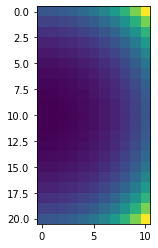

In [12]:
with h5py.File('temp.h5', 'r') as h5file:
    plt.imshow(h5file['output/z'])

# Hyperslabs

Up to this point, you wrote or read entire datasets, but that is not necessary, and often not possible when working with large datasets.  You can use slicing to read (or write) just a subset of the data.  This is called hyperslabs in HDF5 parlance.  For example, you can read only the $z$ values in a rectangle around the origin.

[[1.40494759 1.50681779 1.64872127 1.8404314 ]
 [1.28402542 1.37712776 1.50681779 1.68202765]
 [1.19721736 1.28402542 1.40494759 1.56831219]
 [1.13882838 1.22140276 1.33642749 1.4918247 ]
 [1.10517092 1.18530485 1.29693009 1.44773461]
 [1.09417428 1.17351087 1.28402542 1.43332941]
 [1.10517092 1.18530485 1.29693009 1.44773461]
 [1.13882838 1.22140276 1.33642749 1.4918247 ]
 [1.19721736 1.28402542 1.40494759 1.56831219]
 [1.28402542 1.37712776 1.50681779 1.68202765]]
<class 'numpy.ndarray'>


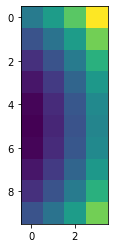

In [13]:
with h5py.File('temp.h5', 'r') as h5file:
    z_dset = h5file['output/z']
    idx = tuple(map(lambda x: x//2, z_dset.shape))
    width = tuple(map(lambda x: x//4, z_dset.shape))
    data = z_dset[idx[0] - width[0]:idx[0] + width[0], idx[1] - width[1]:idx[1] + width[1]]
    print(data)
    print(type(data))
    plt.imshow(data)

Note that the result of the slicing of an HDF5 dataset is a numpy array.

You can also use slices to write data to a dataset.  The data is clipped row by row.

In [14]:
with h5py.File('temp.h5', 'a') as h5file:
    threshold = 1.5
    z_dset = h5file['output/z']
    for row_nr in range(z_dset.shape[0]):
        row = z_dset[row_nr, :]
        row[row > threshold] = threshold
        z_dset[row_nr, :] = row

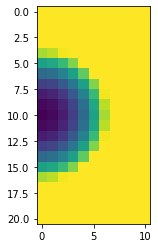

In [15]:
with h5py.File('temp.h5') as h5file:
    plt.imshow(h5file['output/z'])

In [16]:
!h5dump temp.h5

HDF5 "temp.h5" {
GROUP "/" {
   GROUP "input" {
      DATASET "x" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 11 ) / ( 11 ) }
         DATA {
         (0): 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
      DATASET "y" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 21 ) / ( 21 ) }
         DATA {
         (0): -1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0,
         (11): 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
      }
   }
   GROUP "output" {
      DATASET "z" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 21, 11 ) / ( 21, 11 ) }
         DATA {
         (0,0): 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
         (1,0): 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
         (2,0): 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
         (3,0): 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
         (4,0): 1.43333, 1.44773, 1.49182, 1.

Note that indices for hyperslabs can be list, as you can do for numpy arrays.

# Attributes

You can set attributes, i.e., annotations on groups as well as datasets.

In [17]:
with h5py.File('temp.h5', 'a') as h5file:
    h5file.attrs['experiment'] = 'by trial and error'
    h5file['input'].attrs['description'] = 'x/y coordinates'
    h5file['input/x'].attrs['units'] = 'km'
    h5file['input/x'].attrs['desciption'] = 'x-coordinates'
    h5file['input/y'].attrs['units'] = 'km'
    h5file['input/y'].attrs['desciption'] = 'y-coordinates'
    h5file['output'].attrs['desciption'] = 'fields'
    h5file['output/z'].attrs['desciption'] = 'temperature'
    h5file['output/z'].attrs['units'] = 'K'

In [18]:
!h5dump temp.h5

HDF5 "temp.h5" {
GROUP "/" {
   ATTRIBUTE "experiment" {
      DATATYPE  H5T_STRING {
         STRSIZE H5T_VARIABLE;
         STRPAD H5T_STR_NULLTERM;
         CSET H5T_CSET_UTF8;
         CTYPE H5T_C_S1;
      }
      DATASPACE  SCALAR
      DATA {
      (0): "by trial and error"
      }
   }
   GROUP "input" {
      ATTRIBUTE "description" {
         DATATYPE  H5T_STRING {
            STRSIZE H5T_VARIABLE;
            STRPAD H5T_STR_NULLTERM;
            CSET H5T_CSET_UTF8;
            CTYPE H5T_C_S1;
         }
         DATASPACE  SCALAR
         DATA {
         (0): "x/y coordinates"
         }
      }
      DATASET "x" {
         DATATYPE  H5T_IEEE_F64LE
         DATASPACE  SIMPLE { ( 11 ) / ( 11 ) }
         DATA {
         (0): 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1
         }
         ATTRIBUTE "desciption" {
            DATATYPE  H5T_STRING {
               STRSIZE H5T_VARIABLE;
               STRPAD H5T_STR_NULLTERM;
               CSET H5T_CSET_UTF8;
             

Attributes behave like dictionaries, they can be indexed by name, and have methods such as `keys`, `values` and `items`.

In [19]:
with h5py.File('temp.h5', 'r') as h5file:
    for key, value in h5file['output/z'].attrs.items():
        print(f'{key}: "{value}"')

desciption: "temperature"
units: "K"


# Clean up

In [20]:
!rm temp.h5